# Project 2 - Word Prediction Algorithms
Alvaro Aguado

##Project Summary
Search engines, phones, and email all actively employ word prediction to aid users and drive active use. But how do these prediction algorithms really work in principle and in practice? In this project, I aim to answer both by exploring the theoretical nature of the problem, some of its solutions, and the implementation of those solutions.

##Introduction
Word prediction is a feature of many technologies we interact with frequently that has increasingly been taken for granted. In its predominant form, "autocomplete" attemps to aid text messages constantly throughout the day for a tremendous amount of users. In other mediums, like email, "Smart Reply" features hope to offer us a contextually relevant response to an email we've received.

##Katz's Back-off Model
"Katz back-off is a generative *n*-gram language model that estimates the conditional probability of a word given its history in the *n*-gram. It accomplishes this estimation by *backing off* through progressively shorter history models under certain conditions." By doing so, the model with the most reliable information about a given history is used to provide the better results.

\begin{aligned}P_{{bo}}(w_{i}\mid w_{{i-n+1}}\cdots w_{{i-1}})={} &{\begin{cases}d_{{w_{{i-n+1}}\cdots w_{{i}}}}{\dfrac  {C(w_{{i-n+1}}\cdots w_{{i-1}}w_{{i}})}{C(w_{{i-n+1}}\cdots w_{{i-1}})}} &{\text{if }}C(w_{{i-n+1}}\cdots w_{i})>k\\[10pt]\alpha _{{w_{{i-n+1}}\cdots w_{{i-1}}}}P_{{bo}}(w_{i}\mid w_{{i-n+2}}\cdots w_{{i-1}}) & {\text{otherwise}}\end{cases}}\end{aligned}

where 

  ${C(x)} = $ number of times x appears in training <br>
  ${w_i} = $ ith word in the given context <br>
  ${d} = $ is the amount of discounting found by [Good-Turing](https://en.wikipedia.org/wiki/Good%E2%80%93Turing) estimation <br>
  


alpha is the normalization of the left-over probability 

  $\alpha = \dfrac {\beta_{w_{{i-n+1}}\cdots w_{{i-1}}}} {\sum_{ \{w_i:C(w_{{i-n+1}}\cdots {{w_i}})\leq k\}} P_{bo}(w_i\mid w_{{i-n+2}}\cdots w_{{i-1}}) } $ <br>
  
  beta here is the left over probability <br>

  $\beta = 1 - \sum_{\{w_i:C(w_{{i-n+1}}\cdots {{w_i}})\leq k\}}^{} d_{{w_{{i-n+1}}\cdots w_{{i}}}} {\dfrac  {C(w_{{i-n+1}}\cdots w_{{i-1}}w_{{i}})}{C(w_{{i-n+1}}\cdots w_{{i-1}})}} $

In simple terms, Katz's Back-off Model is an *n*-gram language model that estimates conditional probability of the next word given its history in the *n*-gram. And *n*-gram is a string containing *n* words. For example, consider the phrase "I want to eat Chinese food." There are the following *n*-grams:

Unigrams: *I; want; to; eat; Chinese; food*

Bigrams: *I want; want to; to eat; eat Chinese; Chinese food*

Trigrams: *I want to; want to eat; to eat Chinese; eat Chinese food*

Four-grams: *I want to eat; want to eat Chinese; to eat Chinese food*

*etc.*

Essentially, this means that if the n-gram has been seen more than $k$ times in training, the conditional probability of a word given its history is proportional to the maximum likelihood estimate of that n-gram. Otherwise, the conditional probability is equal to the back-off conditional probability of the (n-1)-gram.

As this scales with larger corpuses, we will have a vector that is primarily filled with 0s, which is wasteful of computational resources. We will employ cleaning techniques as a first step, bearing in mind problems that are unique to the nature of our data:

- Ignoring case
- Ignoring punctuation
- Replace #*hashtag* with `hashtagWord`
- Replace *@* with `handleWord`
- Using Lemmatization

Lemmas remove morphological variations on a word. For example,  
- *running* -> *run*
- *spaces* -> *space*
- *better* -> *good*

### Submission:
----------------
The steps followed in this analysis follow CRISP-DM Methodology (**C**ross **I**ndustry **S**tandard **P**rocess for **D**ata **M**ining). Our report consist of the following parts:

- What Data Mining Methods are appropriate for this dataset 
- Data Mining approach: CRISP-DM Methodology
    1. **Business Understanding** 
    2. **Data Understanding**
        - Load and explore the data
        - Evaluate correlations among variables
    3. **Data Preparation**
        - Limit outliers, handling missing data, change variables from categorial to numerical
        - Select features
        - Normalize the target
    4. **Analysis and Modeling**
        - Run Back-off model as base
        - Run the Neural Network to compare
        - Check results and iterate to improve train model
    5. **Evaluation**
        - Assess out-of-sample Accuracy
        - Description of results
        - Conclusions





### 1. Business Understanding/ Objective
For this project our business problem is to create a word predictor or recommender. Our tool should be able to take any string in the English language and be able to make a prediction whether we have zero or more words. The users of the tool should be able to test sentences and automatically get a response from our tool. Given that this problem is very complex, our tool is going to provide 3 candidates words as predictions, and the probability that based on our training set we think these predicted words could be picked. 

The business application could be for a phone company that needs to make a keyboard that recommends the next word as people are typing, or for typing software (Word, Email, Blog) that wants to provide the function autocomplete. 
Although it is not scoped for this project we think the tool should expand it's vocabulary and tailor responses to individuals. This is, that our training dictionary will get updated as the user interacts with the tool, giving higher weight to the words that this user normally uses. We will explain what will be our strategy as next steps in the Deployment Phase. 

**Business Objective:** Create a Word prediction tool that can be reused by the client's application. 


### 2. Data Understanding

We have a dataset that contains multiple entries from different social platforms. Specifically we will be collecting data from FORUMS, BLOGS, NEWS sites and TWITTER. All entries are categorized as English Language by the data provider but there might be instances in which entries are written or contain substrings in other languages. 

Let's start by loading the appropiate libraries and taking a look at the data.

In [0]:
## Import libraries

import pandas as pd                 # Treat data as Data Frames and Series
from sklearn.model_selection import train_test_split # Split our data set into train and test
import numpy as np                  # Numeric Calculations
import random                       # To ensure we can reproduce the example
import re                           # Regular Expressions
import nltk                         # Natural Language Toolkit for tokenizing words
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
import pickle
import heapq
nltk.download('punkt',quiet = True)              # This tokenizer divides text into a list of sentences. Mustt be trained on large set of plaintext in intended language.
nltk.download('stopwords', quiet = True)          # Words like [the, a, an in] that are contextually incosequential and would take up space in our database and therefore processing time.
#nltk.download('PorterStemmer')     # Stemmers remove morphological fixations from words, leaving only the stem. Ex: running -> run; spaces -> space (We used Lemmas instead)
nltk.download('wordnet', quiet = True)            # Lemmas are the same as the Stemmers but the outputted word is readable in the english language

dat = "https://github.com/alvaroaguado3/PredictiveWord/blob/master/SocialData.xlsx?raw=true"
dat_raw = pd.read_excel(dat)

dat_raw.shape

(20000, 7)

In [0]:
import warnings; warnings.simplefilter('ignore')

Our data contains 20,000 rows and 7 variables. If we look at the internal structure of the dataset we can see the following attributes:
 * UniqueID: Which is a unique identifier per row. Each row corresponds to a tweet, blog, news or forum entry. 
 * GroupID: Unique Identifier within each Source. This value is unique within each source (tweets, Blogs, News or Forum entry)
 * Source: Source of the corpus entry. Either TWITTER, BLOG, FORUMS or NEWS. There are 5,000 entries per source. 
 * Date: Date in which the entry was posted. Data was collected between July 22th, 2019 and October 19th, 2019
 * Author: Alias of the author of the tweet, Blog, News or Forum entry. 
 * Country: Country in which the user is registered to be posting the entry. It might not correspond to the country from which the data was posted. 
 * Contents: Raw corpus of the post entry. Each entry could have different lengths in terms of the number of characters. Post may contain special characters that can only be read in UTF-8 encoding.
 

In [0]:
print('Data entries were posted between: ',np.max(dat_raw.Date),'and',np.min(dat_raw.Date))

Data entries were posted between:  2019-10-19 00:00:00 and 2019-07-22 00:00:00


In [0]:
dat_raw.head() # Example of some entries of the data set 

,UniqueID,GroupID,Source,Date,Author,Country,Contents
0,1,1,TWITTER,2019-09-11,drjohnkanca3,US,@washingtonpost The heroes were in those plane...
1,2,2,TWITTER,2019-09-23,Eleven88degrees,US,shut the fuck up my guy.
2,3,3,TWITTER,2019-09-06,ForeverSlime1,GB,Add me to fifa gcs 😁
3,4,4,TWITTER,2019-09-26,KennethT_Realty,US,Even #Millennials are buying homes 😉! Looking ...
4,5,5,TWITTER,2019-09-27,ParentRdMin,US,"Well, that was unusual! We don't answer phone ..."


In [0]:
## Let's check that each entry has the same amount of entries
dat_raw["Source"].value_counts()

NEWS       5000
TWITTER    5000
FORUMS     5000
BLOGS      5000
Name: Source, dtype: int64

From the source counts we will not be giving more weight to one source more than the others. However, because Forum  and Blogs entries tend to have bigger corpus sizes in terms of words than News and Twitter,we will in turn create a bigger dictionary from those sources.

In [0]:
dat_raw["Country"].value_counts()

US    13335
GB     3256
AU     2239
CA     1170
Name: Country, dtype: int64

All entries will come in English language. Most entries come from the US which could mean that the dictionary could be bias towards American English. Our hope is that the representation of other countries can account for the individual nuances of each English dialect.

In [0]:
# Check the average number of words per data source
pd.DataFrame({'Source': dat_raw.Source, 'WordCounts' : [len([x for x in str(sentence).split(" ")]) for sentence in dat_raw.Contents], 'Contents' : dat_raw.Contents}).groupby('Source').WordCounts.mean()


Source
BLOGS      170.9226
FORUMS      43.5626
NEWS        26.4518
TWITTER     22.2172
Name: WordCounts, dtype: float64

It's not surprising to see taht Blogs have the longest entries with 171 words on average across the 5000 entries. On the other side Twitter has the lowest with an average length of 22 words per entry.

### 3. Data Preparation

We proceed now to data preparation. This is the most important phase because depending how we process the data we will get different results. There are several challenges with the data that we need to solve. 

**Cleaning the data:**

* #Hashtags: Social Media data contains several Hashtags. These are anchers for search purposes. Contextually they don't provide a lot of information about the next word, but it's more of a label for the entry. As a result we will replace all the hashtags with a generic word called HashtagWord, this way we know that the word is a special word called hashtag. 

* @Handles: Similarly Handles are a way for user to tag a person to the post or entry. Because this doesn't provide a lot of information about the next word we are going to substitute handles with the special generic word called HandleWord

* Url's: Url's are long strings that provide a link to another url. This again does not provide value to the prediction. We will substitute url's with the generic word UrlWord. 

* Emoji's: Emoji's are ideograms used in electronic messages and webpages. Emoji's are commonly used to represent feelings of the author. The text representation of the unicode encoding is created with a U+ followed by a 4-digit alphanumeric code. Because each emoji could provide some context in sources like twitter we decided to leave emojis as part of the analysis.  

* Punctuation: English language uses punctuation characters such as ? ! . , etc. These could provide some context about the next word but it would increase the complexity of our model for the current scope. For this reason we will remove these characters 

* Special Characters: Even though the text is in english langugage there might be instances when users have special characters from other langugages (i.e. Chinese or japanese characters) or simply characters that are part of Unicode 13 list. We will remove these characters from our analysis.


**N-grams**

N-grams are ways in which we split the courpus of a text. In our analysis our N-grams will be defined by words which are the characters separated by a space. The lowest level N-gram used for our analysis will be unigrams which correspond to individual words. Higher level N-grams like bigrams and trigrams are the combination of consecutive unigrams. We consider that the higher n-gram used the more information is contained about the next word that we are going to predict. For the Kat'z Back off model we will use Unigrams, Bigrams, Trigrams and Fourgrams.

<img src="https://i.stack.imgur.com/8ARA1.png" alt="enter image description here">

**Stemming and Lemmatization**

English language uses words that could have different terminations or suffixes. These suffixes normally are used normally in two forms, for verb conjugations and for noun plurals vs. single indication. Stemming tries to modify words by using the base of the word or Stem this reduces the number of permutations of the same words in our dictionary. Because these don't change the meaning of the words and we want to limit the model complexity and because Stem's alone are hard sometimes to read we are going to use lemma's. Lemmatization takes into consideration the morphological analysis of the words. In order to use lematization we will use pre-trained models to remove the suffixes and normalize to a readable word.

<ul>
<p> **Example of Stemming process:** </p>
<img src="https://blog.bitext.com/hs-fs/hubfs/stemming_v2.png?width=248&amp;height=130&amp;name=stemming_v2.png" align='center'/>
</ul>

<ul>
<p>**Example of Lemmatization process:**</p>
<img width="624" height="450" src="https://searchingforbole.files.wordpress.com/2018/01/re-learning-english-multiple1.png?w=624"/>
</ul>



In [0]:
lens = pd.DataFrame({"lens":[len([x for x in str(sentence).split(" ")]) for sentence in dat_raw.Contents]})
dat_raw = dat_raw[lens['lens'] > 2]

In [0]:
# We will start creating a train and a test set
train, test = train_test_split(dat_raw, test_size=0.01,random_state = 12345)
train.sort_values(by=['Source'], inplace=True,ascending = False)

In [0]:
train.sample(n = 5, random_state=12345).head() #

,UniqueID,GroupID,Source,Date,Author,Country,Contents
611,612,612,TWITTER,2019-09-23,colleen_ashley1,GB,The term for when the grapes start to go from ...
7540,7541,2541,FORUMS,2019-08-30,Rain_06-04-17,US,Thank you. It’s definitely worth it not to dri...
492,493,493,TWITTER,2019-09-29,HobbitLtd,GB,Why not come and have tea with us in our Hobbi...
8052,8053,3053,FORUMS,2019-08-01,Railcarmover,US,"Quote: : Wow, so there is one here! Does anybo..."
4303,4304,4304,TWITTER,2019-10-08,miguueelitoo,US,"finally accepted shit. sleepless nights, weigh..."


Below we implement our first set of functions. 
* Clean_article will take an entry (one corpus) and will perform all the cleaning actions we talked about previously (Handles, emoji's, Hashtags, special characters, etc.). The function will return a clean string (or corpus)

* Get_ngrams will perform the ngrams for a vector of corpus. The function will return a data frame with 4 additional columns: Unigrams, Bigrams, Trigrams and Fourgrams.

* Clean and Uni just performs the combination of the past two functions.

In [0]:
# First we have to pre-process the data and tokenize the inputs 
lemma = WordNetLemmatizer() # Pre-trained algorithm to convert words into lemma's and as a result remove permutations.
porter = nltk.stem.PorterStemmer() #Not used: porter Stemmer coverts words into stem's to remove permutations

# Function takes a string and returns a clean string without special words and characters
def clean_article(article):
  # String to replace URL. This method is not the most exhaustive as the one we have just below but it works computationally more effectively
    p = r"http\S+" 
#    p = r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))'''
    art0 = re.sub(p,' URLWord',article) # Replace url
    art1 = re.sub('@[A-Za-z0-9]+',' HandleWord',art0) # Replace Handle
    art2 = re.sub('#[A-Za-z0-9]+',' HashtagWord',art1) # Replace Hashtag
    art3 = re.sub("n't","nt",art2)
    art4 = re.sub(r'(?<=\w)[^\s\w](?![^\s\w])', ' ', art3) 
    art5 = re.sub("[^A-Za-z]", ' ', art4) # Remove special characters
    art6 = re.sub("\s[B-HJ-Zb-hj-z]\s", ' ', art5)
    art7 = re.sub("^[B-HJ-Zb-hj-z]\s", ' ', art6)
    art8 = re.sub("\s[B-HJ-Zb-hj-z]$", ' ', art7)
    art9 = re.sub('  +', ' ',art8).lstrip().rstrip()    # Strip off double spaces and left and right trimming
    return art9.lower()

# We are going to use Lemmatization instead of Stemming to improve readbility
#def get_ngrams(data_frame):
#  data_frame["unigrams"] = [[porter.stem(x) for x in sentence.split(" ")] for sentence in data_frame.clean]
#  data_frame["bigrams"] = [list(nltk.ngrams([porter.stem(x) for x in sentence.split(" ")],2)) for sentence in data_frame.clean]
#  data_frame["trigrams"] = [list(nltk.ngrams([porter.stem(x) for x in sentence.split(" ")],3)) for sentence in data_frame.clean]
#  data_frame["fourgrams"] = [list(nltk.ngrams([porter.stem(x) for x in sentence.split(" ")],4)) for sentence in data_frame.clean]
#  return data_frame

# Create a data.frame with n-grams and clean string content
def get_ngrams(data_frame):
  data_frame["unigrams"] = [[lemma.lemmatize(x) for x in sentence.split(" ")] for sentence in data_frame.clean]
  data_frame["bigrams"] = [list(nltk.ngrams([lemma.lemmatize(x) for x in sentence.split(" ")],2)) for sentence in data_frame.clean]
  data_frame["trigrams"] = [list(nltk.ngrams([lemma.lemmatize(x) for x in sentence.split(" ")],3)) for sentence in data_frame.clean]
  data_frame["fourgrams"] = [list(nltk.ngrams([lemma.lemmatize(x) for x in sentence.split(" ")],4)) for sentence in data_frame.clean]
  return(data_frame)

# Create dataframe with only unigrams and clean string content
def clean_and_uni(data_frame):
    data_frame["clean"] = data_frame.apply(lambda row: clean_article(str(row["Contents"])), axis=1)
    data_frame["unigrams"] = [[lemma.lemmatize(x) for x in sentence.split(" ")] for sentence in data_frame.clean]
    return(data_frame)

# Count instances of the ngram, returns a dictionary with word + count
def freq(ngrams):
    lst = []
    for s in ngrams:
        for w in s:
            lst.append(w)            
    return(nltk.FreqDist(lst))


In [0]:
# Apply cleaning function to train and test 
## Warning: This takes sometime to run 1-2 mins since it has to clean all data inputs
train["clean"] = train.apply(lambda row: clean_article(str(row["Contents"])), axis=1)
test["clean"] = test.apply(lambda row: clean_article(str(row["Contents"])), axis=1)

# Make n-grams
df_train = get_ngrams(train)
df_test = get_ngrams(test)

In [0]:
lens = pd.DataFrame({"lens":[len([x for x in str(sentence).split(" ")]) for sentence in train.clean]})
train = train.iloc[np.where(lens['lens'] > 2)]

In [0]:
# See the dictionary of n-grams pulled
df_train.loc[:,["unigrams","bigrams","trigrams","fourgrams","Contents"]].head(100)
#df_test.loc[:,["unigrams","bigrams","trigrams","fourgrams","Contents"]].head(100)


,unigrams,bigrams,trigrams,fourgrams,Contents
1729,"[the, stationmaster, daughter, by, kathleen, m...","[(the, stationmaster), (stationmaster, daughte...","[(the, stationmaster, daughter), (stationmaste...","[(the, stationmaster, daughter, by), (stationm...",The Stationmaster's Daughter by Kathleen McGur...
437,"[go, follow, handleword, get, access, to, her,...","[(go, follow), (follow, handleword), (handlewo...","[(go, follow, handleword), (follow, handleword...","[(go, follow, handleword, get), (follow, handl...",Go follow @chanelb82413021 Get access to her O...
3607,"[handleword, handleword, handleword, handlewor...","[(handleword, handleword), (handleword, handle...","[(handleword, handleword, handleword), (handle...","[(handleword, handleword, handleword, handlewo...",@radiophonicpop @TalentedEukarya @questauthori...
4540,"[best, part, about, baby, sitting, older, kid,...","[(best, part), (part, about), (about, baby), (...","[(best, part, about), (part, about, baby), (ab...","[(best, part, about, baby), (part, about, baby...",Best part about baby sitting older kids is I c...
3829,"[handleword, and, in, the, sunshine, think, mr...","[(handleword, and), (and, in), (in, the), (the...","[(handleword, and, in), (and, in, the), (in, t...","[(handleword, and, in, the), (and, in, the, su...",@rescuedogdexter And in the sunshine 😍 think M...
...,...,...,...,...,...
23,"[handleword, a, a, big, city, person, i, alway...","[(handleword, a), (a, a), (a, big), (big, city...","[(handleword, a, a), (a, a, big), (a, big, cit...","[(handleword, a, a, big), (a, a, big, city), (...",@soult As a big-city person I'm always surpris...
1048,"[handleword, handleword, stolen, your, dream, ...","[(handleword, handleword), (handleword, stolen...","[(handleword, handleword, stolen), (handleword...","[(handleword, handleword, stolen, your), (hand...",@Reuters @GretaThunberg Stolen your dreams? WT...
692,"[new, post, chris, bosh, on, the, nba, final, ...","[(new, post), (post, chris), (chris, bosh), (b...","[(new, post, chris), (post, chris, bosh), (chr...","[(new, post, chris, bosh), (post, chris, bosh,...",New post (Chris Bosh On The 2013 NBA Finals) h...
2655,"[no, joke, this, wa, picture, number, for, the...","[(no, joke), (joke, this), (this, wa), (wa, pi...","[(no, joke, this), (joke, this, wa), (this, wa...","[(no, joke, this, wa), (joke, this, wa, pictur...",No Joke. This Was Picture Number For The First...


We can now compare if train and test sets are similar in the type of words we find in the datasets.

In [0]:
# Build Dictionaries by N-gram
dict_4 = freq(df_train.fourgrams)
dict_3 = freq(df_train.trigrams)
dict_2 = freq(df_train.bigrams)
dict_1 = freq(df_train.unigrams)
dict_test_4 = freq(df_test.fourgrams)
dict_test_3 = freq(df_test.trigrams)
dict_test_2 = freq(df_test.bigrams)
dict_test_1 = freq(df_test.unigrams)

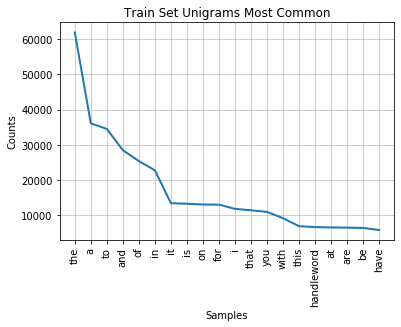

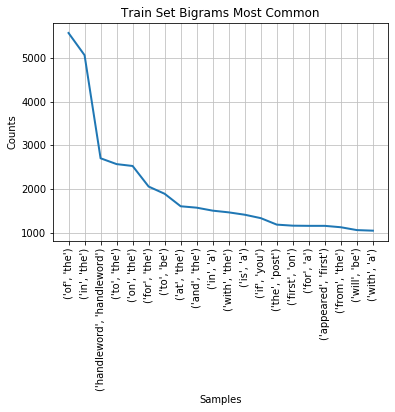

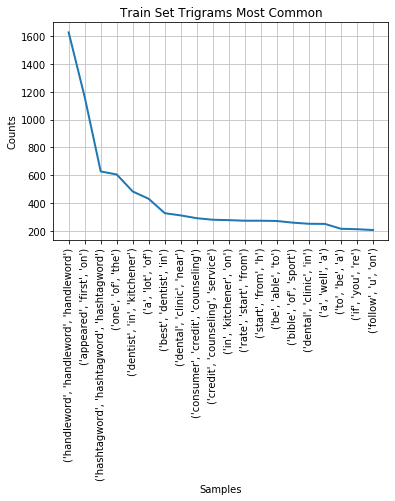

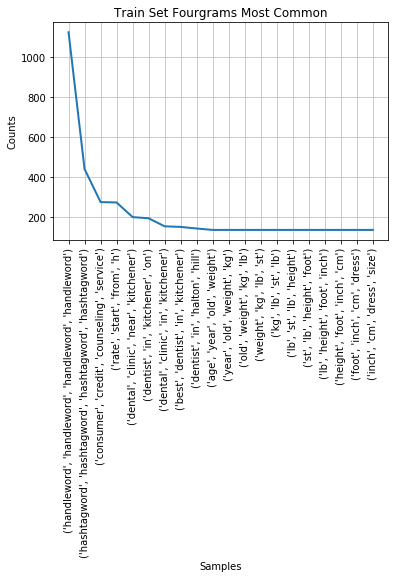

In [0]:
# Most common ngrams for the train set
dict_1.most_common(10)    
dict_2.most_common(10) 
dict_3.most_common(10) 
dict_4.most_common(10) 

# Plots by ngram for the train set
plt.title("Train Set Unigrams Most Common")
dict_1.plot(20,cumulative=False)
plt.title("Train Set Bigrams Most Common")
dict_2.plot(20,cumulative=False)
plt.title("Train Set Trigrams Most Common")
dict_3.plot(20,cumulative=False)
plt.title("Train Set Fourgrams Most Common")
dict_4.plot(20,cumulative=False)


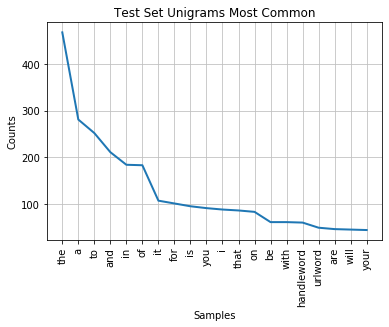

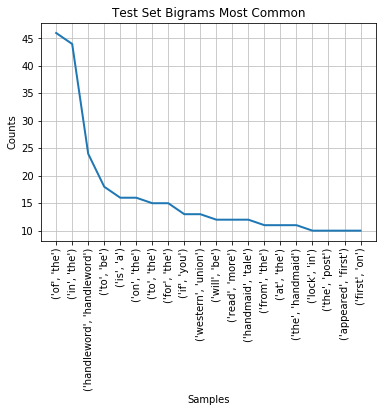

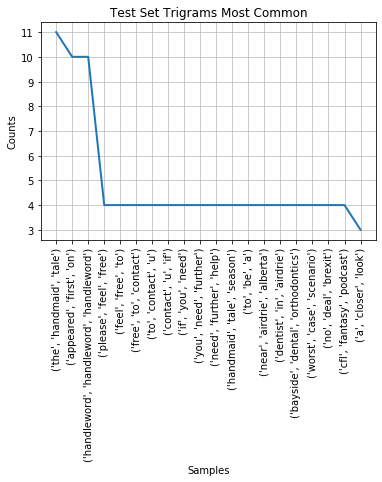

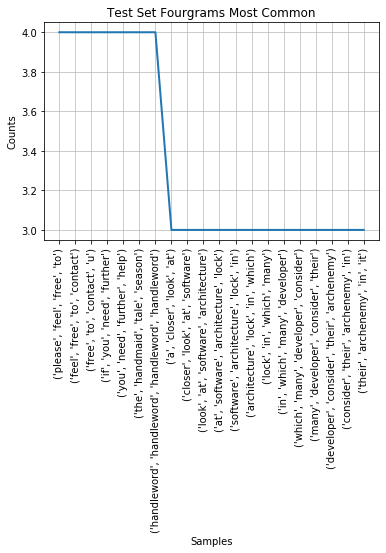

In [0]:
# Most common ngrams for the test set
dict_test_1.most_common(10)    
dict_test_2.most_common(10) 
dict_test_3.most_common(10) 
dict_test_4.most_common(10) 

# Plots by ngram for the test set
plt.title("Test Set Unigrams Most Common")
dict_test_1.plot(20,cumulative=False)
plt.title("Test Set Bigrams Most Common")
dict_test_2.plot(20,cumulative=False)
plt.title("Test Set Trigrams Most Common")
dict_test_3.plot(20,cumulative=False)
plt.title("Test Set Fourgrams Most Common")
dict_test_4.plot(20,cumulative=False)

We can compare how our train set has similar distribution of unigrams and bigrams as the test set. However, as we move up to tri-grams and four-grams we find that there are many instances that are not present in the most common train set. This tells us that trigrams and fourgrams contain a lot more information and that their frequencies are more unique to the text that is being processed.

One more thing we have to do is to treat new or unkown words. Our train set is a large composition of words but it doesn't have every single word that can be written. Far from that we probably have a small dictionary. There are 2 things we could do: 
1. We continue to increase our dictionary size to make sure that we cover every word possible
2. We do a pre-processing to new words that checks if the word is in the dictionary. In case it doesn't then we convert the word to a special word 'Unk'

None of the approaches are ideal but this would help our algorithms process data more efficiently

In [0]:
dict_1[lemma.lemmatize('midstream')]

1

In [0]:
def get_in_dict(article,dict):
  lst = []
  for x in article.split(" "):
    x = lemma.lemmatize(x)
    if dict.get(x,34727) == 0:
      lst.append(re.sub(x,"UNK",x))
    else:
      lst.append(x)
  article_new = ' '.join(lst)
  return(article_new)


We will apply this when we build our train_target and test_target data frames. Also we will create an entry in our dictionary to account for the word UNK. Below is an example of what will this function do to the data

In [0]:
def pre_proc(article,dict):
  new_article = clean_article(article)
  return(get_in_dict(new_article,dict))

In [0]:
example = "I can't stand this ksjddkjghs OMG"
pre_proc(example,dict_1)

'i cant stand this ksjddkjghs omg'

Now that we have pre-processed the data we have to create a function to prepare our test set. 
Currently our test set looks exactly as our train set; a vector of (pre-processed) corpuses with target variable to compare to. For this we need to create a function that takes the text vector and randomly selects a subset of the corpus string, and also generates a target variable that will be the word right after the subset of the corpus selected. 

For example if the test set has the following sample strings:

|actual| contents   |
|------|------------|
|     1| We want to go to the movies and then maybe go to a bar.          |
|     2| If we don't fight wildfires we are likely to lose the flora of the region.|
|     3|Remember to call me!!!!|

Our function is going to return the following

|actual| subset     |target|
|------|------------|------|
|     1| We want to go to |the|
|     2| If we don't fight wildfires we are|likely|
|     3|Remember to |call|

this way our model will take the input from the subset column and will try to predict the target variable. 

If the subset doesn't have enough words to form the higher level grams it will directly try to predict based on the highest level n-gram possible and succesively go down the n-gram order level. 

Also, in order to define pick the best value for k (min frequency) and d (good-turing discount), we are going to cross validate our train set until we have the highest level possible level for training.


In [0]:
# We first need to create a function that will take the test set and break the string into target, 
# and subset which is the sentence preceding the word to be predicted

# Function to create a target column from a random length in the test strings
def create_target(data_frame,type = 0):
  # Create target takes a data frame with a column Contents that contains the text strings and returns the data frame in addition to the following variables:
  # clean: Contents string cleaned by removing punctuation, hashtags, handles, etc.
  # n-grams: 4 columns with the different ngrams. each contains tuples with the n-gram from the clean variable
  # target: variable with the word (unigram) to be predicted
  # length: number of unigrams preceding the target variable. We are going to force to have at least 3 words for the prediction
    random.seed(12345)
    test_set = pd.DataFrame(columns = ['clean','target','length'])
    data_frame["clean"] = data_frame.apply(lambda row: pre_proc(str(row["Contents"]),dict_1), axis=1)
#    data_frame["clean"] = data_frame.apply(lambda row: get_in_dict(str(row["clean"]),dict_1), axis=1)
    data_frame["unigrams"] = [[lemma.lemmatize(x) for x in sentence.split(" ")] for sentence in data_frame.clean]
    sen = []
    tar = []
    pos = []
    for x in data_frame.unigrams:
      if type == 1:
        if len(x) < 1:
          print("This string is empty!")
        else:
          posi = len(x)-1
          #print("Selecting substring with ",posi,"words out of ",len(x)," total available words")
        sentence = ' '.join(x[0:(posi)])
        target = ''        
        test_set = test_set.append({'clean': sentence,'target': target,'length':posi},ignore_index = True)
      elif type == 0:
        if len(x) < 1:
            #print("This string is empty, then skip")
            continue
        elif len(x) < 3:
            posi = len(x)-1
            #print("Selecting substring with ",posi,"words out of ",len(x)," total available words")
        else:        
            posi = random.randint(2,len(x)-1)        
            #print("Selecting substring with ",posi,"words out of ",len(x)," total available words")
        sentence = ' '.join(x[0:(posi)])
        target = x[posi]
        sen.append(sentence)
        tar.append(target)
        pos.append(posi)

    test_set = pd.DataFrame(list(zip(sen,tar,pos)),columns = ['clean','target','length'])
    test_set['unigram'] = last_gram(test_set.clean,1)
    test_set['bigram'] = last_gram(test_set.clean,2)
    test_set['trigram'] = last_gram(test_set.clean,3)
    test_set['fourgram'] = last_gram(test_set.clean,4)    
    return(test_set)

# Get the last set of ngrams from the sentence to be tested
def last_gram(base,n):
    last_ngram = [list(nltk.ngrams([j for j in sentence.split(" ")[-n:]],n)) for sentence in base]
    return(last_ngram)



Let's create from the test set the target word to predict along with the n-gram that precede the word. The selection of the target word is random but it will be reproducible because we selected unique seed 12345.

In [0]:
import random
# train_target = create_target(train,type = 0)
# Test
test["clean"] = test.apply(lambda row: clean_article(str(row["Contents"])), axis=1)
test_target = create_target(test,type = 0)

In [0]:
# Resulting Set to predict
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    print(test_target.loc[:,["clean","target"]])
test_target.loc[:,["clean","target"]]


,clean,target
0,it currently rain and celsius outside so use,your
1,source urlword a closer look at software archi...,which
2,friendly reminder,if
3,i ve been up,since
4,yeah he only a top passer right now but he onl...,he
...,...,...
194,really i found the act of actually watching mad,men
195,i hope that the gop isnt,that
196,handleword handleword there the,plan
197,do you have any out fan or are they all in,your


Now the Back off model will take the largest probability of the largest n-gram possible and predicts the next word. At the lowest level if we don't know the word then use the most common unigram.

In [0]:
## Back-off Algorithm
## Returns the prediction and probability
## Probability is not being stored correctly
# Top function
def get_candidates(data_frame):
  # takes a pre-processed data_frame (from the create_target function) and returns the same data frame with 2 additional columns
  # pred: which is the predicted word
  # prob: which is the estimated probability
    pred = []
    prob = []
    for i in range(len(data_frame)):
        #print(i)
        s4,s3,s2,s1 = get_ngram_col(data_frame,i)
        if len(s4) != 0:
            resp, proba = get_prediction(s3,s4,dict_3,dict_4)
        elif len(s3) != 0:
            resp, proba = get_prediction(s2,s3,dict_2,dict_3)
        elif len(s2) != 0:
            resp, proba = get_prediction(s1,s2,dict_1,dict_2)            
        else:
            l = len(dict_1)
            t = np.sum(list(dict_1.values()))
            resp, proba = dict_1.most_common(1)[0][0],(dict_1.most_common(1)[0][1]/t)
        pred.append(resp)
        prob.append(proba)
    data_frame['pred'] = pred
    data_frame['proba'] = proba
    return(data_frame)

# Find ngram in dictionary for evaluation. Returns 4 instances that are to be passed to function get_prediction
def get_ngram_col(data_frame,i):
    l = data_frame.length[i]    
    if l >= 4:
        w4 = data_frame.iloc[i][6][0]
    else:
        w4 = []        
    if l >= 3:
        w3 = data_frame.iloc[i][5][0]
    else:
        w3 = []    
    if l >= 2:
        w2 = data_frame.iloc[i][4][0]
    else:
        w2 = []    
    w1 = data_frame.iloc[i][3][0][0]
    s4 = [item for item in dict_4 if item[0:3] == w3]
    s3 = [item for item in dict_3 if item[0:2] == w2]
    s2 = [item for item in dict_2 if item[0] == w1]
    s1 = [item for item in dict_1 if item == w1]
    return(s4,s3,s2,s1)

# From get_gram_ncol calculate the probability of getting the next word. Highest ngram wins
def get_prediction(S,s,F,f):        
    dem = F[S[0]]
    ds = []
    for i in range(len(s)):
        #print(i)
        #i = 1
        num = f[s[i]]
        p = num/dem
        ds.append(p)
        
    ind = ds.index(max(ds))
    probability = max(ds)
    response = s[ind][-1:][0]
    return(response,probability)


In [0]:
# Make prediction
# Warning: takes about 30 seconds to run
result_frame = get_candidates(test_target)
result_frame.iloc[:,[1,3,4,5,7]] # Here we predict the results, if the target is equal to the pred then our prediction is correct, otherwise is not

,target,unigram,bigram,trigram,pred
0,your,"[(use,)]","[(so, use)]","[(outside, so, use)]",whoever
1,which,"[(in,)]","[(lock, in)]","[(architecture, lock, in)]",a
2,if,"[(reminder,)]","[(friendly, reminder)]",[],that
3,since,"[(up,)]","[(been, up)]","[(ve, been, up)]",to
4,he,"[(and,)]","[(game, and)]","[(nfl, game, and)]",click
...,...,...,...,...,...
194,men,"[(mad,)]","[(watching, mad)]","[(actually, watching, mad)]",men
195,that,"[(isnt,)]","[(gop, isnt)]","[(the, gop, isnt)]",a
196,plan,"[(the,)]","[(there, the)]","[(handleword, there, the)]",copper
197,your,"[(in,)]","[(all, in)]","[(they, all, in)]",the


In [0]:
correct = 0
for i in range(len(result_frame)):
  if result_frame.iloc[i,1] == result_frame.iloc[i,7]:
    correct += 1

print("The number of correct predictions is:",correct," out of",len(result_frame))

The number of correct predictions is: 32  out of 199


As we can see, stupid back-off model predicts correctly 32 out of 199 words correctly, 16% correct which is not bad for a model that basically doesn't use smoothed Maximum likelihood logic to predict the next word.